In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init


#import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴

import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

from torchvision import datasets, transforms, models  # models 임포트 추가

!pip install datasets
# 데이터셋 불러오기
from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# DOCCI 데이터셋 로드 -> 대신에 옥스포드 펫으로 모의 테스트
ds = load_dataset('pcuenq/oxford-pets')  # DOCCI 데이터셋 경로에 맞게 변경

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## CNN

In [7]:
#아주아주 완벽한? CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

# Bottleneck Block used in ResNet-50
class block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride =1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride =1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):  #[3,4,6,3]
    def __init__(self, block, layers, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1,
                                                          stride=stride),
                                                nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride)) #첫블럭에서만 다운샘플? 나머진 아래 반복문
        self.in_channels = out_channels * 4

        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64, 64*4 (다시 256)

        return nn.Sequential(*layers) #각각의 레이어가 차례로 나옴

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        #x = torch.flatten(x, 1)  # 벡터화하여 출력

        return x


def ResNet50(img_channels =3, num_classes= 1000):
    return ResNet(block, [3, 4, 6, 3],img_channels, num_classes)

def test():
    net = ResNet50()
    x = torch.randn(2, 3, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)

print(test)

<function test at 0x7a9591e339a0>


## 데이터 전처리

데이터 셋 분리 과정. 6:2:2 로 분리했음

In [ ]:
print(ds)

# 학습 데이터셋 분리
train_val_dataset = ds['train'].train_test_split(test_size=0.4)  # 60%를 학습, 40%를 검증+테스트

# 검증과 테스트 데이터셋 분리
val_test_dataset = train_val_dataset['test'].train_test_split(test_size=0.5)  # 50%를 검증, 50%를 테스트

# 최종 데이터셋 구성
train_dataset = train_val_dataset['train']
val_dataset = val_test_dataset['train']
test_dataset = val_test_dataset['test']
print()
print(ds['train'].column_names)
print()
print(ds['train'].features)
# 결과 확인

print(train_dataset)
print(val_dataset)
print(test_dataset)
#plt.imshow(train_dataset['image'][0])



DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 7390
    })
})

['path', 'label', 'dog', 'image']

{'path': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None), 'dog': Value(dtype='bool', id=None), 'image': {'bytes': Value(dtype='binary', id=None), 'path': Value(dtype='string', id=None)}}
Dataset({
    features: ['path', 'label', 'dog', 'image'],
    num_rows: 4434
})
Dataset({
    features: ['path', 'label', 'dog', 'image'],
    num_rows: 1478
})
Dataset({
    features: ['path', 'label', 'dog', 'image'],
    num_rows: 1478
})


### CNN에 사용할 데이터셋 전처리

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# 이미지 전처리: 크기 조정 및 텐서 변환
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),   # 이미지 크기 조정
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 정규화
])

# 데이터셋에서 이미지와 레이블 추출하여 CNN에 맞게 변환
class DogImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)
        return image, label


# DataLoader 설정
train_loader = DataLoader(DogImageDataset(train_dataset, image_transforms), batch_size=32, shuffle=True)
val_loader = DataLoader(DogImageDataset(val_dataset, image_transforms), batch_size=32)
test_loader = DataLoader(DogImageDataset(test_dataset, image_transforms), batch_size=32)


###Transformer 에 쓸 데이터 전처리

In [ ]:
from transformers import AutoTokenizer

# Pre-trained tokenizer 사용 (예: BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 텍스트 데이터를 Transformer 모델에 맞게 변환
class DogTextDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, tokenizer, max_length=77):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['label']
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return encoded['input_ids'].squeeze(), encoded['attention_mask'].squeeze()

# DataLoader 설정
train_text_loader = DataLoader(DogTextDataset(train_dataset, tokenizer), batch_size=32, shuffle=True)
val_text_loader = DataLoader(DogTextDataset(val_dataset, tokenizer), batch_size=32)
test_text_loader = DataLoader(DogTextDataset(test_dataset, tokenizer), batch_size=32)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### 전처리한 데이터들 통합

In [ ]:
from PIL import Image  # PIL을 통해 이미지를 불러올 때 필요할 수 있음

class DogImageTextDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, image_transform, tokenizer, max_length=77):
        self.dataset = dataset
        self.image_transform = image_transform
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # 이미지 변환
        image_data = self.dataset[idx]['image']
        if isinstance(image_data, dict) and 'bytes' in image_data:
            image = Image.open(io.BytesIO(image_data['bytes']))
        else:
            image = image_data  # PIL 이미지 객체로 이미 변환되어 있는 경우

        if self.image_transform:
            image = self.image_transform(image)

        # 텍스트 변환
        text = self.dataset[idx]['label']
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoded['input_ids'].squeeze()
        attention_mask = encoded['attention_mask'].squeeze()

        return image, input_ids, attention_mask


# DataLoader 설정
train_combined_loader = DataLoader(
    DogImageTextDataset(train_dataset, image_transforms, tokenizer),
    batch_size=32, shuffle=True
)
val_combined_loader = DataLoader(
    DogImageTextDataset(val_dataset, image_transforms, tokenizer),
    batch_size=32
)
test_combined_loader = DataLoader(
    DogImageTextDataset(test_dataset, image_transforms, tokenizer),
    batch_size=32
)


In [ ]:
print(train_combined_loader)

In [ ]:
print(train_combined_loader)

건들지말기. 데이터셋 확인겸 이미지 띄워본거임.

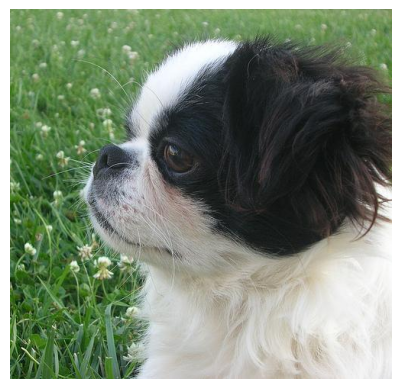

/data/datasets/magic-ml/oxford-iiit-pet/images/japanese_chin_183.jpg
japanese chin
True


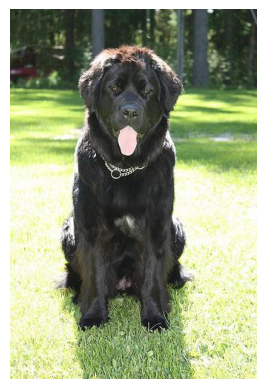

/data/datasets/magic-ml/oxford-iiit-pet/images/newfoundland_88.jpg
newfoundland
True


In [ ]:

from PIL import Image
import io

# 1,2 번째 이미지의 경로 또는 바이트 데이터 가져오기
for i in range(2):
  image_data = train_dataset['image'][i]['bytes']  # 바이너리 형식으로 가져오기

  # 이미지 데이터에서 PIL 이미지로 변환
  img = Image.open(io.BytesIO(image_data))

  # 이미지 출력
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  print(train_dataset['path'][i])
  print(train_dataset['label'][i])
  print(train_dataset['dog'][i])

In [ ]:
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# 이미지 변환 설정 (ResNet-50 용)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # ResNet50 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def preprocess_image(image):
    image = Image.open(image).convert("RGB")  # 이미지 파일 열기
    return image_transforms(image)  # 전처리 후 반환


## Transformer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads): #임베딩을 여러부분으로 분할
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "임베딩 사이즈가 heads로 나누어 떨어져야 함"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False) #Linear_v
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False) #Linear_k
        self.queries == nn.Linear(self.head_dim, self.head_dim, bias=False) #Linear_q
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)  #Linear_out

        # v k q 는 모두 동일하지만 용도가 달라 나눈 것

    def forward(self, values, keys, query, mask):
        N = query.shape[0] # 동시에 보내는 훈련예제의 수?
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # 임베딩을 heads 조각들로 나눈다
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        energy = torch.einsum("nqhd,nkhd -> nhqk", [query, keys])
        # 쿼리 shape : (N, query_len, heads, head_dim)  # 키 shape : (N, key_len, heads, head_dim)
        # energy shape = (N, heads, query_len(타겟), key_len(인풋))
        if mask is not None:
            energy = scores.masked_fill(mask == 0, float("-1e9")) #자리값을 매우작은걸로 씌우는?

        #소프트맥스 함수를 구현
        attention = torch.softmax(energy / (slef.embed_size ** (1/2)), dim=3)

        output = torch.einsum("nhql,nlhd -> nqhd",[attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )
        # attention shape : (N, heads, query_len, key_len)
        # 벨류 shape : (N, velue_len, heads, heads_dim)
        # einsum 이후엔 (N, query_len, heads, head_dim) 가됨. flattend last two dimensions

        out = self.fc_out(out)
        return out



class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerEncoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.Add_norm1 = nn.LayerNorm(embed_size)
        self.Add_norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.sequential(
            nn.Linear(embed_size, forward_expansion*embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion*embed_size, embed_size)
        )
        self.dropout = nn.Dropout(dropout)


    def forward(self, values, keys, query, mask):
        attention = self.attention(values, keys, query, mask)
        x = self.dropout(self.Add_norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.Add_norm2(forward + x))

        return out

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

class Encoder(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 device,
                 forward_expansion,
                 dropout,
                 max_length=76
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerEncoderBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion
                )
            ]
        )
        self.dropout = nn.Dropout(dropout)


    def forward(self, x, mask=None):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

        out = self.dropout(self.word_embedding(x) + self.positional_encoding(positions))

        for layer in self.layers:
            out = layer(out,out,out, mask)

        return out


#지금까지 인코더 완료, 디코더 시작.

class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(TransformerDecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.Add_norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(
            embed_size, heads, dropout, forward_expansion
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask) #인코더블럭의 젤 아랫부분
        query = self.dropout(self.Add_norm(attention + x))
        out = self.transformer_block(value, key, query, src_mask)
        return out
class Decoder(nn.Module):
    def __init__(self,
                 trg_vocab_size,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 dropout,
                 device,
                 max_length=76
    ):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerDecoderBlock(embed_size, heads, forward_expansion, dropout, device)
             for _ in range(num_layers)]
        )

        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout((self.word_embedding(x) + self.position_embedding(positions)))

        for layer in self.layers:
            x = layer(x, enc_out, enc_out, src_mask, trg_mask)

        out = self.fc_out(x)

class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 trg_vocab_size,
                 src_pad_idx,
                 trg_pad_idx,
                 embed_size=256,
                 num_layers=6,
                 forward_expansion=4,
                 heads=8,
                 dropout=0,
                 device="cuda",
                 max_length=76
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            src_vocab_size,
            embed_size,
            num_layers,
            heads,
            device,
            forward_expansion,
            dropout,
            max_length
        )

        self.decoder = Decoder(
            trg_vocab_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            device,
            max_length
        )

        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # (N, 1, 1, src_len)
        return src_mask.to(self.device)
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            N, 1, trg_len, trg_len
        )
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


#이 아래는 테스트 예제
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    x = torch.tensor([[1, 5, 6, 4, 3, 9, 5, 2, 0], [1, 8, 7, 3, 4, 5, 6, 7, 2]]).to(device)
    trg = torch.tensor([[1, 7, 4, 3, 5, 9, 2, 0], [1, 5, 6, 2, 4, 7, 6, 2]]).to(device)

    src_pad_idx = 0
    trg_pad_idx = 0
    src_vocab_size = 10
    trg_vocab_size = 10
    model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx).to(device)
    out = model(x, trg[:, :-1])
    print(out.shape)
    print(out)

AttributeError: 'SelfAttention' object has no attribute 'queries'

## CLIP

In [ ]:
class CLIPModel(nn.Module):
    def __init__(self, cnn_model, transformer_model, embed_dim=512):
        super(CLIPModel, self).__init__()
        self.cnn_model = cnn_model
        self.transformer_model = transformer_model
        self.image_projection = nn.Linear(2048, embed_dim)  # ResNet50 output dimension to embed_dim
        self.text_projection = nn.Linear(transformer_model.embedding.embedding_dim, embed_dim)

    def forward(self, image, input_ids, attention_mask):
        # 이미지에서 특징 벡터 추출
        image_features = self.cnn_model(image)
        # 텍스트에서 특징 벡터 추출
        text_features = self.transformer_model(input_ids, attention_mask)

        # 벡터를 공통 임베딩 공간으로 투영
        image_embed = self.image_projection(image_features)
        text_embed = self.text_projection(text_features)

        # 코사인 유사도 계산
        image_embed = F.normalize(image_embed, dim=-1)
        text_embed = F.normalize(text_embed, dim=-1)
        similarity = torch.matmul(image_embed, text_embed.T)
        return similarity

In [ ]:
# CLIP 모델 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CLIP 모델 생성
clip_model = CLIPModel(
    cnn_model=ResNet50(num_classes=2048),
    transformer_model=TransformerEncoder(
        num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=30522
    ),
    embed_dim=512
).to(device)

# 학습 루프
for image, input_ids, attention_mask in train_combined_loader:
    # 데이터 장치에 올리기
    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # 모델에 입력
    similarity = clip_model(image, input_ids, attention_mask)

    # 목표값과 비교하여 로스 계산
    # 예: loss = loss_function(similarity, target)
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [ ]:
class CLIPModel(nn.Module):
    def __init__(self, cnn_model, transformer_model, embed_dim=512):
        super(CLIPModel, self).__init__()
        self.cnn_model = cnn_model
        self.transformer_model = transformer_model
        self.image_projection = nn.Linear(2048, embed_dim)  # ResNet50 output dimension to embed_dim
        self.text_projection = nn.Linear(transformer_model.embedding.embedding_dim, embed_dim)

    def forward(self, image, input_ids, attention_mask):
        image_features = self.cnn_model(image)  # 이미지에서 벡터 생성
        text_features = self.transformer_model(input_ids, attention_mask)  # 텍스트에서 벡터 생성

        # 벡터를 공통 임베딩 공간으로 투영
        image_embed = self.image_projection(image_features)
        text_embed = self.text_projection(text_features)

        # 코사인 유사도를 계산하여 반환
        image_embed = F.normalize(image_embed, dim=-1)
        text_embed = F.normalize(text_embed, dim=-1)
        similarity = torch.matmul(image_embed, text_embed.T)
        return similarity


In [ ]:
# CLIP 모델 학습 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CLIP 모델을 생성
clip_model = CLIPModel(
    image_encoder=ResNet50Encoder(),
    text_encoder=TransformerEncoder(
        num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=30522
    )
).to(device)

# 학습 루프
for image, input_ids, attention_mask in train_combined_loader:
    # 이미지와 텍스트 데이터를 장치에 올바르게 전달
    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # 모델에 입력
    image_features, text_features = clip_model(image, input_ids, attention_mask)

    # 로스 계산 등 나머지 학습 과정을 수행


TypeError: CLIPModel.__init__() got an unexpected keyword argument 'image_encoder'

##학습 (동작안함. 데이터전처리 이상함)

In [ ]:
# Example usage with data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel(ResNet50Encoder(), TransformerEncoder(num_layers=6, d_model=512, num_heads=8, d_ff=2048, vocab_size=30522)).to(device)

for image, input_ids, attention_mask in train_combined_loader:
    image = image.to(device)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    similarity = clip_model(image, input_ids, attention_mask)
    print("Image-Text Similarity:", similarity)


TypeError: Unexpected type <class 'dict'>